# Fraud Detection

**Dataset:**
- https://www.kaggle.com/ntnu-testimon/banksim1/code?datasetId=1565&sortBy=voteCount


**Índice:**

1. [Import Packages](#1.0-Imports)
2. [Exploratory Data Analysis](#2.0-EDA)
3. [Data Processing](#3.0-Data-Processing)

    * 3.1 [Funções Iniciais](#3.1-Funções-Iniciais)
    * 3.2 [Pré Processamento](#3.2-Pré-Processamento)

4. [Models](#4.0-Models)

    * 4.1 [Regressão Logistica](#4.1-Regressão-Logistica)
    * 4.2 [Decision Tree](#4.2-Decision-Tree)
    * 4.3 [Random Forest](#4.3-Random-Forest)
    * 4.4 [Naive Bayes](#4.4-Naive-Bayes)
    * 4.5 [Suport Vector Machine](#4.4-Suport-Vector-Machine)

5. [Results](#5.0-Results)

## 1.0 Imports


Importando bibliotecas utilizadas.

In [1]:
import pandas as pd
import os
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Pre processamento
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE

# Modelagem e escolha de parametros
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Métricas
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import plot_confusion_matrix

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importando a base referente ás transações e caracteristicas do cliente
path = 'datasets/credit_fraud_bs.csv'
df = pd.read_csv(path)

df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


## 2.0 EDA - Metadados

**Metadados**

Para o problema de detecção de fraude será utilizado a base 'df_fraud' que possui 9 colunas com informações sobre transações de pagamento online. As colunas são:

* **Step**: Essa coluna representa o dia da transação em relação ao número de dias passados. Nessa simulação temos 180 dias, contando virtualmente 6 meses.

* **Customer**: Identificador unico de cliente (mais de 4000 clientes). Coluna do tipo int64. 

* **Age**: Idade categorizada em faixas, como segue:
    * 0: <= 18, menor ou igual a 18 anos
    * 1: 19-25, entre 19 e 25 anos
    * 2: 26-35, entre 26 e 35 anos
    * 3: 36-45, entre 36 e 45 anos
    * 4: 46:55, entre 46 e 55 anos
    * 5: 56:65, entre 56 e 65 anos
    * 6: > 65 , mais de 65 anos
    * U: Idade Desconhecida
    
* **Gender**: Gênero do cliente. O Grupo "Desconhecido" tem por volta de 170 clientes.

     * E: Empresa,
     * F: Feminino,
     * M: Masculino,
     * U: Desconhecido

Os dois aributos a seguir foram removidos do dataset, já que eles possuem valor constante, pois possuímos o código postal de apenas um lugar.    
* **zipCodeOrigin**: O zip code (código postal) de origem.

* **zipMerchant**: O zip code (código postal) do estabelecimento.

* **Merchant**: Identificador do estabelecimento. Temos 50 estabelecimentos nessa variável categórica.
   
* **Category**: Categoria da compra. Temos 15 categorias quanto ao tipo do produto comprado, como segue:

    * 'es_barsandrestaurants' 
    * 'es_contents' 
    * 'es_fashion'              
    * 'es_food'                  
    * 'es_health'               
    * 'es_home'                 
    * 'es_hotelservices'        
    * 'es_hyper'                 
    * 'es_leisure'              
    * 'es_otherservices'        
    * 'es_sportsandtoys'        
    * 'es_tech'                 
    * 'es_transportation'       
    * 'es_travel'  
    * 'es_wellnessandbeauty' 

* **Amount**: Valor da compra. Neste campo temos apenas valores positivos (e 52 valores iguais a 0).

* **Fraud**: Vaiável Target: 1 se a transação foi fraudulenta, ou 0 se a transação foi regular.

In [4]:
df.info()
#df.head()
#df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [5]:
print('Este conjunto de dados possui ', df.shape[1],' colunas e ', df.shape[0], ' linhas. Dessas estão representados', len(set(df.customer))
          , 'clientes.\n')

Este conjunto de dados possui  10  colunas e  594643  linhas. Dessas estão representados 4112 clientes.



## 3.0 Data Processing

- **Data Join**

Durante o processo de descoberta dos dados contruimos  dataframes distintos de forma a tentar agrupar as informações e explorar esses novos conjunto de dados, são eles:  customer e merchant_group. Iremos trazer essas informações para o dataframe principal seguindo a seguinte lógica abaixo, lembrando que é importante aplicar essas funções nos dataframes já subdividos em treino e teste:

    - Customer Data
    
    Iremos trazer ao dataframe principal algumas informações do histórico do cliente até a data da compra, as colunas que serão adicionadas dizem respeito à caracteristicas do cliente importantes para prever se a transação é ou não uma fraude. As colunas que serão adicionadas são: mean_transactions_costumer, fraud_count_costumer e percent_fraud_costumer.
    
    - Merchant Data
    Iremos trazer ao dataframe principal algumas informações do histórico da loja até a data da compra. As colunas que serão adicionadas são: mean_transactions_merchant, fraud_count_merchant e percent_fraud_merchant.
    
  

- **Limpeza dos dados**

As principais açõies relevantes à essa base de dados são:

        -Retira das colunas : zipcodeOri, zipMerchant, step e costumer

- **Dados Categóricos**

Temos na base principal de transações o total de 4 colunas categóricas que precisarão passar por um processo de transformação por colunas binarias. Vamos adicionar 8 colunas binarias para os grupos de idade, 4 colunas binarias para os grupos de genero, 50 colunas binarias para os grupos de lojas e, por fim, 15 colunas binarias para os grupos de category.



- **Dados Númericos**

Agora com todos os dados devidamente transformados em valores númericos podemos aplicar técnicas de padronização dos dados. Inicialmente a técnica escolhida foi o "StandardScale".


- **Classes Desbalanceadas**

Como neste exemplo temos muito mais observações de transações não fradulentas iremos criar um conjunto de dados sinteticos de forma a balancear as classes dentro do conjunto de dados e, assim, evitar overffiting no experimento.

### 3.1 Tratamento Inicial

In [6]:
############################################ Trazendo valores históricos
########### Groupby costumer:
# Agrupando valores sobre o comportamento de transações por cliente
customer_grouped = df.groupby(['customer']).apply(lambda x: pd.Series(dict(
                                                                mean_transactions_costumer   =  ((x.amount.mean())) 
                                                                ,fraud_count_costumer         =  ((x.fraud.sum()))
                                                                ,percent_fraud_costumer       = ((x.fraud.sum()*100)/((x.amount.count())))
                                                                ))).reset_index()
# Juntando os dados
df = pd.merge(df,customer_grouped, on=['customer'] , how = 'left')


########### Groupby merchant:
# Agrupando valores sobre caracteristicas de transação por loja
merchant_group = df.groupby(['merchant']).\
                        apply(lambda x: pd.Series(dict(mean_transactions_merchant   =  ((x.amount.mean())) 
                                                        ,fraud_count_merchant        =  ((x.fraud.sum()))
                                                        ,percent_fraud_merchant      =  ((x.fraud.sum()/x.fraud.count()*100))
                                                        ))).reset_index()
# Juntando os dados
df = pd.merge(df,merchant_group, how = 'left', on=['merchant'] )

print('Fase de agrupamento de dados históricos concluida')

############################################ Limpando as informações do df principal

# Retira as colunas que não vamos usar
df  = df.drop(['zipcodeOri', 'zipMerchant', 'step' , 'customer', 'merchant'], axis=1)

# Seleciona as colunas categoricas
colunas_categoricas = list(df.select_dtypes('object').columns)

# Cria um df
temp = pd.get_dummies(df[colunas_categoricas])

# Tira as colunas categoricas do df
df = df.drop(colunas_categoricas, axis=1)

# Atualiza o dataframe unindo as informações principais e os valores categoricos
df = pd.merge(df, temp, how = 'left', left_index=True, right_index=True)

Fase de agrupamento de dados históricos concluida


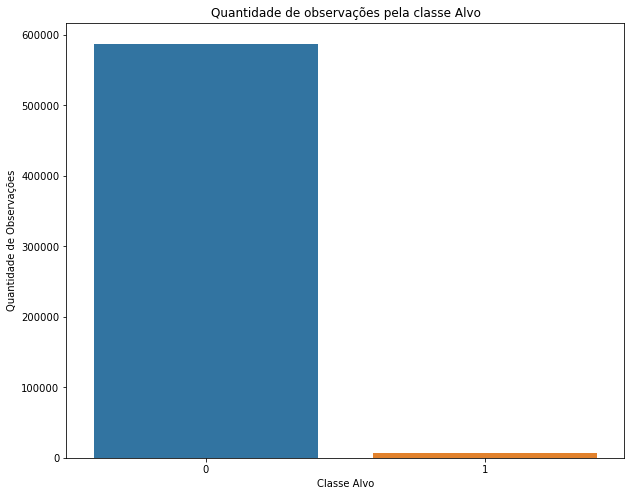

In [7]:
fig, axes = plt.subplots(figsize=(10, 8))

sns.countplot(x="fraud", data=df)

plt.title('Quantidade de observações pela classe Alvo')
plt.xlabel('Classe Alvo')
plt.ylabel('Quantidade de Observações')
plt.show()

### 3.2 Pré Processamento

In [8]:
# Dividindo a base de dados de entrada e o valor resposta referente a transação fraudulentea ou nao

# Tira as coluna alvo
X = df.drop('fraud', axis=1)
y = df['fraud']

# Cria o objeto do escalonador
escalonador = StandardScaler()

# Transforma os dados 
X = escalonador.fit_transform(X)

In [9]:
################################################ Splitando a base
# Divide em base de treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, random_state=42)


################################################ Passando estratégia de oversampling

# Define a estratégia de oversampling
SMOTE = SMOTE()

# treina e aplica a função Smote
X_treino, y_treino = SMOTE.fit_resample(X_treino, y_treino)

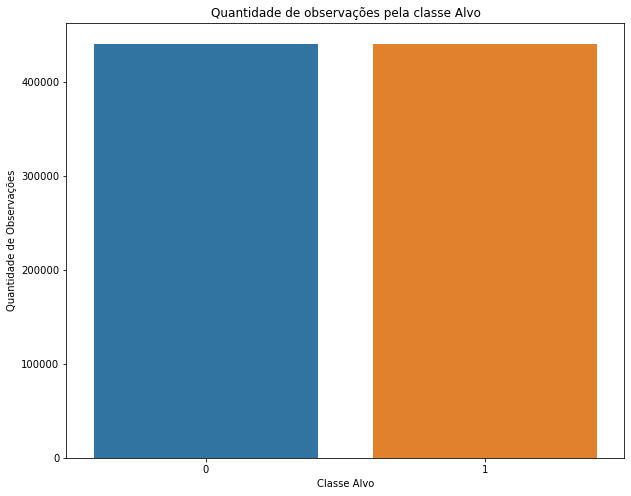

In [10]:
fig, axes = plt.subplots(figsize=(10, 8))

temp = pd.DataFrame(y_treino, columns = ['fraud'])
sns.countplot(x="fraud", data=temp)

plt.title('Quantidade de observações pela classe Alvo')
plt.xlabel('Classe Alvo')
plt.ylabel('Quantidade de Observações')
plt.show()

## 4.0 Models

##### Função de avaliação dos Modelos

In [11]:
# Avaliação de modelos de classificação

def resultados_classificacao(modelo, nome_do_modelo ):
    y_pred = np.nan
    y_pred = modelo.predict(X_teste)
    y_pred_proba = modelo.predict_proba(X_teste)[:, 1]
        
    acuracia  =  accuracy_score(y_teste,y_pred)
    f1        =  f1_score(y_teste, y_pred) 
    precisao  =  precision_score(y_teste, y_pred)
    recall    =  recall_score(y_teste,y_pred)

    print('Resultados:')
    print('Acuracia                     : ', round(acuracia*100, 2) , '%'  )
    print('F1 Score                     : ', round(f1*100, 2)        , '%'  )
    print('Precisão (Precision)         : ', round(precisao*100, 2)  , '%' )
    print('Recall                       : ', round(recall*100 , 2)   , '%'  )

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Matriz de Confusão
    disp = plot_confusion_matrix(modelo, X_teste, y_teste, cmap=plt.cm.Blues, ax = axes[0])

    [fpr, tpr, thr] = roc_curve(y_teste, y_pred_proba)

    idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

    axes[1].plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
    axes[1].plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')

    axes[1].set_xlabel('False Positive Rate (1 - specificity)', fontsize=14)
    axes[1].set_ylabel('True Positive Rate (recall)', fontsize=14)
    axes[1].set_title('Receiver operating characteristic (ROC) curve')
    axes[1].legend(loc="lower right");


### 4.1 Regressão Logistica


Modelo 1 - Logistic Regression

Resultados:
Acuracia                     :  98.45 %
F1 Score                     :  59.95 %
Precisão (Precision)         :  43.1 %
Recall                       :  98.4 %


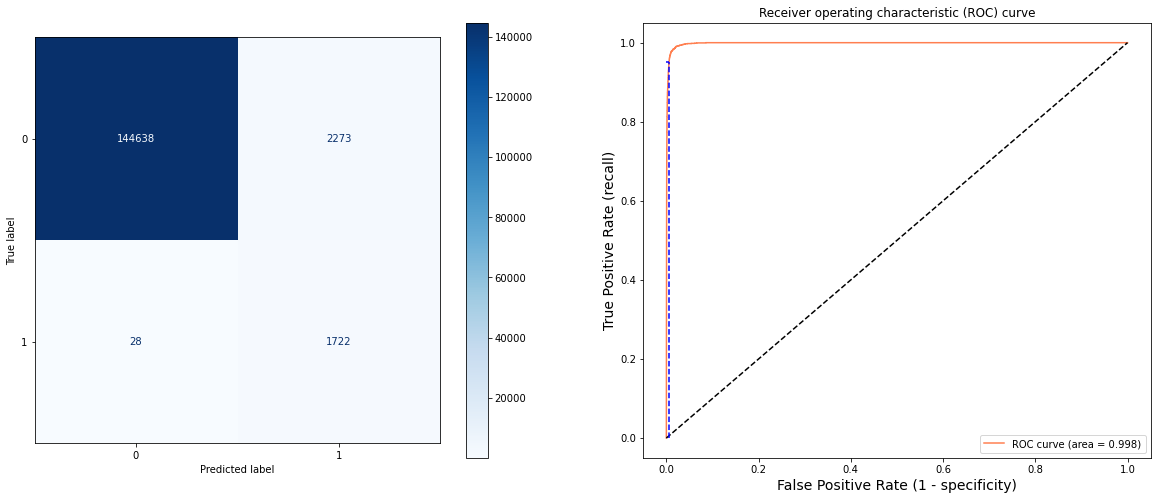

In [12]:
# Logistic Regression

print("Modelo 1 - Logistic Regression\n") 

# Cria o objeto com o modelo do SKLearn
modelo_1 = LogisticRegression()

# Treina o modelo para os dados de Treino
modelo_1.fit(X_treino, y_treino)

# Verifica os resultados
resultados_classificacao(modelo_1, 'Logistic Regression')

### 4.2 Decision Tree


Modelo 2 - Decision Tree Classifier

Resultados:
Acuracia                     :  99.52 %
F1 Score                     :  81.21 %
Precisão (Precision)         :  75.44 %
Recall                       :  87.94 %


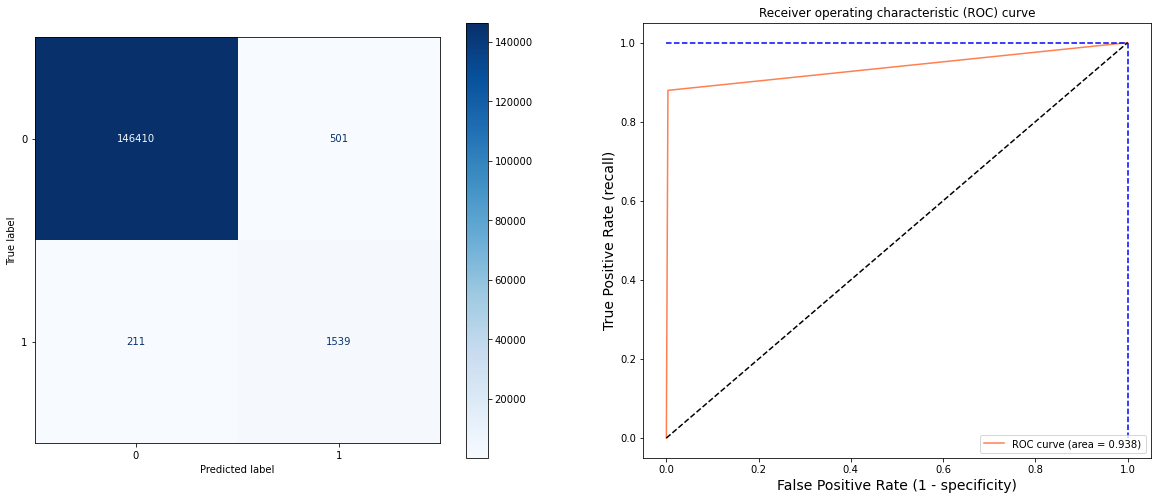

In [13]:
# Decision Tree Classifier

print("Modelo 2 - Decision Tree Classifier\n") 

# Cria o objeto com o modelo do SKLearn
modelo_1 = DecisionTreeClassifier()

# Treina o modelo para os dados de Treino

modelo_1.fit(X_treino, y_treino)

# Verifica os resultados
resultados_classificacao(modelo_1, 'Decision Tree')

### 4.3 Random Forest

Modelo 3 - Random Forest

Resultados:
Acuracia                     :  99.55 %
F1 Score                     :  82.63 %
Precisão (Precision)         :  75.15 %
Recall                       :  91.77 %


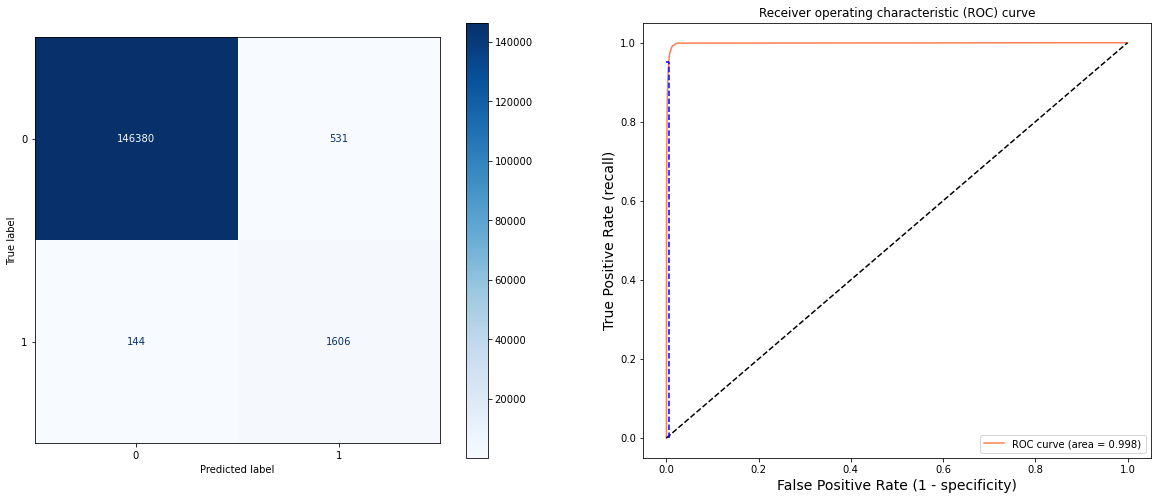

In [14]:
# Random Forest

print("Modelo 3 - Random Forest\n") 

# Cria o objeto com o modelo do SKLearn
modelo_1 = RandomForestClassifier()

# Treina o modelo para os dados de Treino
modelo_1.fit(X_treino, y_treino)

# Verifica os resultados
resultados_classificacao(modelo_1, 'Random Forest')


### 4.4 Naive Bayes

Modelo 4 - Naive Bayes

Resultados:
Acuracia                     :  90.76 %
F1 Score                     :  20.29 %
Precisão (Precision)         :  11.29 %
Recall                       :  99.89 %


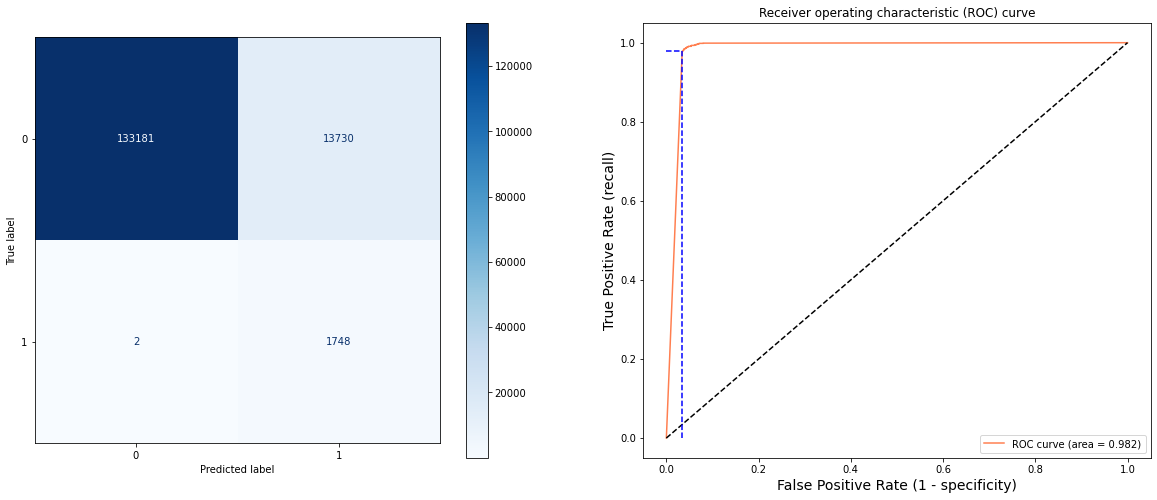

In [15]:
# Naive Bayes

print("Modelo 4 - Naive Bayes\n") 

# Cria o objeto com o modelo do SKLearn
modelo_1 = GaussianNB()

# Treina o modelo para os dados de Treino
modelo_1.fit(X_treino, y_treino)

# Verifica os resultados
resultados_classificacao(modelo_1, 'Naive Bayes')


### 4.5 Suport Vector Machine

In [ ]:
# Suport Vector Machine

print("Modelo 5 - Suport Vector Machine\n") 

# Cria o objeto com o modelo do SKLearn
modelo_1 = SVC(probability=True)

# Treina o modelo para os dados de Treino
modelo_1.fit(X_treino, y_treino)

# Verifica os resultados
resultados_classificacao(modelo_1, 'Suport Vector Machine')

Modelo 5 - Suport Vector Machine

